In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

### M_MGN:

In [5]:
class M_MGN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_modules):
        super(M_MGN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_modules = num_modules

        # Define modules (W_k, b_k, and activation functions)
        self.W_k = nn.ModuleList([
            nn.Linear(input_dim, hidden_dim, bias=True) for _ in range(num_modules)
        ])

        # Each module has its own activation (e.g., tanh, softplus)
        self.activations = nn.ModuleList([nn.Tanh() for _ in range(num_modules)])

        # V^T V term (PSD by construction)
        self.V = nn.Linear(input_dim, input_dim, bias=False)  # Shape: [input_dim, input_dim]
        nn.init.orthogonal_(self.V.weight)  # Initialize V to be orthogonal

        # Bias term (a)
        self.a = nn.Parameter(torch.randn(input_dim))  # Learned bias


    def forward(self, x):
        batch_size = x.shape[0]

        # Initialize output with bias term (broadcasted to batch)
        out = self.a.unsqueeze(0).expand(batch_size, -1)  # Shape: [batch_size, input_dim]

        # Add V^T V x term (ensures PSD Jacobian)
        V_sq = self.V.weight.t() @ self.V.weight  # Shape: [input_dim, input_dim]
        out = out + x @ V_sq  # Shape: [batch_size, input_dim]

        # Loop over modules and compute terms
        for k in range(self.num_modules):
            # Compute z_k = W_k x + b_k
            z_k = self.W_k[k](x)  # Shape: [batch_size, hidden_dim]

            # Compute s_k(z_k) = sum_i log(cosh(z_k_i)) (scalar per sample)
            s_k = torch.sum(torch.log(torch.cosh(z_k)), dim=1)  # Shape: [batch_size]

            # Compute activation σ_k(z_k)
            sigma_k = self.activations[k](z_k)  # Shape: [batch_size, hidden_dim]

            # Compute s_k(z_k) * W_k^T σ_k(z_k)
            W_k_T = self.W_k[k].weight.t()  # Shape: [input_dim, hidden_dim]
            term = (W_k_T @ sigma_k.t()).t()  # Shape: [batch_size, input_dim]
            term = s_k.unsqueeze(-1) * term  # Broadcast s_k and multiply

            out += term

        return out  # Shape: [batch_size, input_dim]

    def logcosh(self, x):
        return torch.log(torch.cosh(x))

In [70]:
def sample_data(batch_size=1000):
    batch = []
    data = []
    for i in range(batch_size):
        x1, x2 = np.random.randint(0, 2), np.random.randint(0, 2)  # Corrected range to (0, 2)
        value = x1**4 + 0.5 * x2 + 0.5 * x1 * x2 + 1.5 * x2**2 - 1/3 * x2**3
        batch.append(value)
    return batch


batch = torch.tensor(sample_data(), dtype=torch.float).unsqueeze(1)

input_dim = batch.shape[1]

model = M_MGN(input_dim, hidden_dim, num_modules)

grad_f_x = model(batch)  # Shape: [10, input_dim]

# Calculate the Jacobian for each sample in the batch
jacobians = [torch.autograd.functional.jacobian(model, batch[i].unsqueeze(0)) for i in range(batch.shape[0])]

# Reshape each Jacobian to be a square matrix
jacobians = [j.reshape(input_dim, input_dim) for j in jacobians]

# Check PSD for each Jacobian in the batch
for jacobian in jacobians:
    assert torch.all(torch.linalg.eigvalsh(jacobian) >= -1e-6), "Jacobian is not PSD"

In [9]:
# Define the function f(x)
def f(x):
    x1, x2 = x[:, 0], x[:, 1]
    return x1**4 + x2/2 + (x1 * x2)/2 + (3 * x2**2)/2 - (x2**3)/3

# Define the true gradient ∇f(x)
def grad_f(x):
    x1, x2 = x[:, 0], x[:, 1]
    df_dx1 = 4 * x1**3 + x2/2
    df_dx2 = x1/2 + 3 * x2 - x2**2
    return torch.stack([df_dx1, df_dx2], dim=1)  # Shape: [batch_size, 2]

In [7]:
# Generate 1 million random points in the unit square
num_samples = 1_000_000
x = torch.rand(num_samples, 2)  # Shape: [num_samples, 2]

# Compute the true gradient ∇f(x) for each point
true_grad = grad_f(x)  # Shape: [num_samples, 2]

In [8]:
# Initialize the M-MGN model
input_dim = 2  # x is 2D
hidden_dim = 32  # Example hidden dimension
num_modules = 5  # Number of modules
model = M_MGN(input_dim, hidden_dim, num_modules)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.L1Loss()  # Mean absolute error (MAE)

# Training loop
batch_size = 1024  # Example batch size
num_epochs = 10  # Number of epochs

for epoch in range(num_epochs):
    for i in range(0, num_samples, batch_size):
        # Get batch of data
        x_batch = x[i:i + batch_size]
        true_grad_batch = true_grad[i:i + batch_size]
        
        # Forward pass
        pred_grad_batch = model(x_batch)
        
        # Compute loss
        loss = criterion(pred_grad_batch, true_grad_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.44184550642967224
Epoch 2, Loss: 0.1820482462644577
Epoch 3, Loss: 0.07567357271909714
Epoch 4, Loss: 0.025815164670348167
Epoch 5, Loss: 0.011251325719058514
Epoch 6, Loss: 0.006993032060563564
Epoch 7, Loss: 0.005859538912773132
Epoch 8, Loss: 0.00475230673328042
Epoch 9, Loss: 0.0055260988883674145
Epoch 10, Loss: 0.00516177574172616


In [9]:
# Generate test data
test_samples = 100_000
x_test = torch.rand(test_samples, 2)
true_grad_test = grad_f(x_test)

# Evaluate the model
model.eval()
with torch.no_grad():
    pred_grad_test = model(x_test)
    test_loss = criterion(pred_grad_test, true_grad_test)
    print(f"Test Loss (MAE): {test_loss.item()}")

Test Loss (MAE): 0.004236495587974787


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


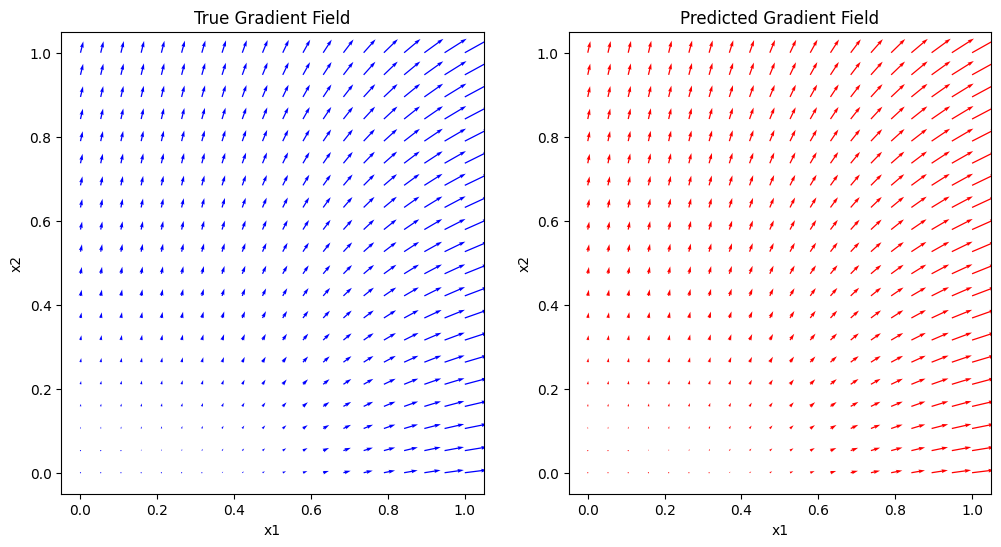

In [10]:
import matplotlib.pyplot as plt

# Generate a grid of points for visualization
grid_size = 20
x1 = torch.linspace(0, 1, grid_size)
x2 = torch.linspace(0, 1, grid_size)
x1_grid, x2_grid = torch.meshgrid(x1, x2)
x_grid = torch.stack([x1_grid.flatten(), x2_grid.flatten()], dim=1)

# Compute true and predicted gradients on the grid
true_grad_grid = grad_f(x_grid)
with torch.no_grad():
    pred_grad_grid = model(x_grid)

# Reshape for visualization
true_grad_grid = true_grad_grid.reshape(grid_size, grid_size, 2)
pred_grad_grid = pred_grad_grid.reshape(grid_size, grid_size, 2)

# Plot true gradient field
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.quiver(x1_grid, x2_grid, true_grad_grid[:, :, 0], true_grad_grid[:, :, 1], color='blue')
plt.title("True Gradient Field")
plt.xlabel("x1")
plt.ylabel("x2")

# Plot predicted gradient field
plt.subplot(1, 2, 2)
plt.quiver(x1_grid, x2_grid, pred_grad_grid[:, :, 0], pred_grad_grid[:, :, 1], color='red')
plt.title("Predicted Gradient Field")
plt.xlabel("x1")
plt.ylabel("x2")

plt.show()

### ICNNs:

In [6]:
class ICNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(ICNN, self).__init__()
        # Define ReLU activation
        self.relu = nn.ReLU()

        # Use nn.ModuleList for layers to ensure they are registered as model parameters
        self.modules_x = nn.ModuleList([nn.Linear(input_dim, hidden_dim, bias=True) for _ in range(num_layers)])
        self.modules_z = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim, bias=False) for _ in range(num_layers)])

        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        # Initialize zl as a zero tensor with the same device as x
        zl = torch.zeros(x.shape[0], self.modules_x[0].out_features, device=x.device)
        for i in range(len(self.modules_x)):
            self.modules_z[i].weight.data.clamp_(min=0)
            zl = self.relu(self.modules_z[i](zl) + self.modules_x[i](x))  # Apply ReLU activation
        return zl

    def _initialize_weights(self):
        # Loop through all layers and apply Xavier initialization
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)  # Apply Xavier uniform initialization
                if module.bias is not None:
                    init.zeros_(module.bias)  # Initialize biases to 0

In [13]:
# Initialize the M-MGN model
input_dim = 2  # x is 2D
hidden_dim = 1  # Example hidden dimension
num_modules = 5  # Number of modules
model = ICNN(input_dim, hidden_dim, num_modules).to('cuda')

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.L1Loss()  # Mean absolute error (MAE)

num_samples = 1_000_000
x = torch.rand(num_samples, 2)  # Shape: [num_samples, 2]
true_fx = f(x)

# Training loop
batch_size = 1024  # Example batch size
num_epochs = 30  # Number of epochs

for epoch in range(num_epochs):
    for i in range(0, num_samples, batch_size):
        # Get batch of data
        x_batch = x[i:i + batch_size]
        true_fx_batch = true_fx[i:i + batch_size]
        
        # Forward pass
        pred_fx_batch = model(x_batch.to('cuda'))
        
        # Compute loss
        loss = criterion(pred_fx_batch.to('cuda'), true_fx_batch.unsqueeze(1).to('cuda'))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.09407000243663788
Epoch 2, Loss: 0.0412365086376667
Epoch 3, Loss: 0.032853372395038605
Epoch 4, Loss: 0.03106597438454628
Epoch 5, Loss: 0.03034294955432415
Epoch 6, Loss: 0.029815852642059326
Epoch 7, Loss: 0.029445268213748932
Epoch 8, Loss: 0.029046880081295967
Epoch 9, Loss: 0.028734780848026276
Epoch 10, Loss: 0.028472311794757843
Epoch 11, Loss: 0.028269747272133827
Epoch 12, Loss: 0.02819783240556717
Epoch 13, Loss: 0.028123749420046806
Epoch 14, Loss: 0.028101563453674316
Epoch 15, Loss: 0.02804848924279213
Epoch 16, Loss: 0.02806996740400791
Epoch 17, Loss: 0.028041183948516846
Epoch 18, Loss: 0.028040511533617973
Epoch 19, Loss: 0.02801504358649254
Epoch 20, Loss: 0.028035985305905342
Epoch 21, Loss: 0.028037497773766518
Epoch 22, Loss: 0.02803872339427471
Epoch 23, Loss: 0.02806553617119789
Epoch 24, Loss: 0.028045926243066788
Epoch 25, Loss: 0.02808264270424843
Epoch 26, Loss: 0.028063589707016945
Epoch 27, Loss: 0.02806844376027584
Epoch 28, Loss: 0.02808

In [15]:
# Forward pass
x = torch.randn(10, input_dim, device='cuda')  # Batch of 10 samples
conv_f_x = model(x)  # Shape: [10, input_dim]


# Calculate the Jacobian for each sample in the batch
jacobians = [torch.autograd.functional.jacobian(model, x[i]) for i in range(x.shape[0])]

# Reshape each Jacobian to be a square matrix
jacobians = [j.reshape(input_dim, input_dim) for j in jacobians]

# Check PSD for each Jacobian in the batch
for jacobian in jacobians:
    assert torch.all(torch.linalg.eigvalsh(jacobian) >= -1e-6), "Jacobian is not PSD"

AssertionError: Jacobian is not PSD

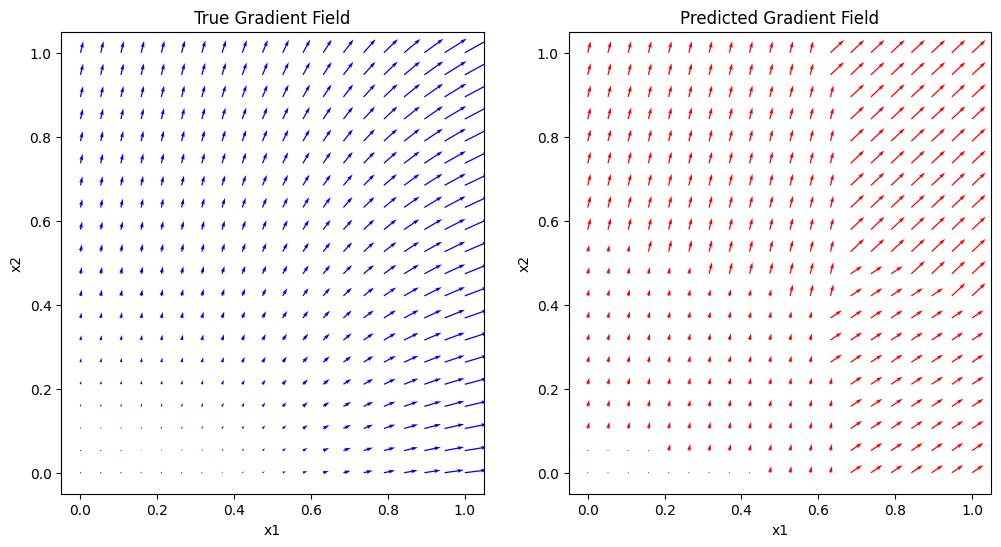

In [18]:
# Generate a grid of points for visualization
grid_size = 20
x1 = torch.linspace(0, 1, grid_size)
x2 = torch.linspace(0, 1, grid_size)
x1_grid, x2_grid = torch.meshgrid(x1, x2, indexing='ij')  # Use 'ij' indexing for standard meshgrid behavior
x_grid = torch.stack([x1_grid.flatten(), x2_grid.flatten()], dim=1).to('cuda')  # Ensure x_grid is on CUDA

# Compute true gradients on the grid
true_grad_grid = grad_f(x_grid)  # Replace with your custom function

# Compute predicted gradients
x_grid.requires_grad = True  # Enable gradient tracking for x_grid
pred_fx_grid = model(x_grid)  # Pass grid points through the model
pred_fx_grid.sum().backward()  # Backprop to compute gradients
pred_grad_grid = x_grid.grad  # Extract gradients w.r.t. input

# Reshape for visualization
true_grad_grid = true_grad_grid.reshape(grid_size, grid_size, 2)
pred_grad_grid = pred_grad_grid.reshape(grid_size, grid_size, 2)

# Plot true gradient field
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.quiver(x1_grid.cpu(), x2_grid.cpu(), 
           true_grad_grid[:, :, 0].cpu(), true_grad_grid[:, :, 1].cpu(), 
           color='blue')  # Plot true gradients
plt.title("True Gradient Field")
plt.xlabel("x1")
plt.ylabel("x2")

# Plot predicted gradient field
plt.subplot(1, 2, 2)
plt.quiver(x1_grid.cpu(), x2_grid.cpu(), 
           pred_grad_grid[:, :, 0].cpu(), pred_grad_grid[:, :, 1].cpu(), 
           color='red')  # Plot predicted gradients
plt.title("Predicted Gradient Field")
plt.xlabel("x1")
plt.ylabel("x2")

plt.show()
